In [1]:
#@title Installing Packages
!pip install scanpy[leiden]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.0/296.0 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
#@title Mount Google Drive 

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Mounted at /content/drive


# 1 single cell clustering in tumor samples

It is a data set published in the [Tirosh _et al._](https://science.sciencemag.org/content/352/6282/189.full) paper in 2016. The data set contains 4,600 cells from 19 melanoma tumors. The data is also available in GEO under accession number [GSE72056](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72056).

You may also find the data on these google drive (feel free to request access :)):

* [skcm_gse72056_scrna_tpm.txt.gz](https://drive.google.com/file/d/1-BUTEVdMq5dyMfWVldFgBo4DOOkR5HSV/view?usp=share_link) : Expression data

* [skcm_gse72056_scrna_meta.txt](https://drive.google.com/file/d/1-Fke9zko84xMH_mHs1zJLd2CJ_OhPpD3/view?usp=share_link) : Sample meta data

First, let's load the data. We will need to transpose the gene expression matrix so its dimension is `(num_samples, num_genes)`. 

In [ ]:
import pandas as pd
from pathlib import Path
import scanpy as sc

# set scanpy plotting parameter to dpi = 150
sc.settings.set_figure_params(dpi=150)

# change this to where you save the data
DATA = Path("/content/drive/My Drive/2022 ECBM E4060/data/hw4")

In [ ]:
ge = sc.read_csv(DATA / "skcm_gse72056_scrna_tpm.txt.gz",
                 delimiter="\t").transpose()
meta = pd.read_csv(DATA / "skcm_gse72056_scrna_meta.txt", sep="\t",
                   index_col=0)

# to prevent some issues later, we rename the tumor columns with prefix 't'
meta["tumor"] = "t" + meta.tumor.astype(str)

ge.shape

(4645, 23684)

In [ ]:
ge

AnnData object with n_obs × n_vars = 4645 × 23684

To make sure you have read the data correctly, you should see 4,645 samples and 23,684 genes. Note for the meta data we load the `tumor` column as `str` to make sure they are categorical. This will help with the coloring in the next steps.

Next we will concatenate the cell metadata to the loaded `AnnData` object in `scanpy` (the object you generated using `sc.read_csv` function). To do that, simply concatenate the `pd.DataFrame` of metadata to the `obs` field in your `AnnData` object. After doing that you should see your `obs` field to be exactly as the meta data.

In [ ]:
ge.obs.head()

Empty DataFrame
Columns: []
Index: [Cy72_CD45_H02_S758_comb, CY58_1_CD45_B02_S974_comb, Cy71_CD45_D08_S524_comb, Cy81_FNA_CD45_B01_S301_comb, Cy80_II_CD45_B07_S883_comb]

In [ ]:
meta.head()

tumor cell_type_annot_by_author
Cy72_CD45_H02_S758_comb       t72                         B
CY58_1_CD45_B02_S974_comb     t58                         T
Cy71_CD45_D08_S524_comb       t71                 malignant
Cy81_FNA_CD45_B01_S301_comb   t81                 malignant
Cy80_II_CD45_B07_S883_comb    t80                 malignant

In [ ]:

ge.obs = pd.concat([ge.obs, meta.loc[ge.obs_names]], axis=1, sort=False)
ge.raw = ge.copy()

ge.obs.head()

tumor cell_type_annot_by_author
Cy72_CD45_H02_S758_comb       t72                         B
CY58_1_CD45_B02_S974_comb     t58                         T
Cy71_CD45_D08_S524_comb       t71                 malignant
Cy81_FNA_CD45_B01_S301_comb   t81                 malignant
Cy80_II_CD45_B07_S883_comb    t80                 malignant

Now we have the data loaded and merged

---



The samples include both cancer cells and other, mainly immune, cells. The authors have annotated them based on the cells' copy number variation information. As in the paper, Let's analyze the cancer cells and immune cells separately. So we will split the `ge` object into two: `ge_cancer` and `ge_immune` by subsetting the `ge` object based on whether the `cell_type_annot_by_author` column is `malignant` or not.

In [ ]:
ge.var_names

Index(['C9orf152', 'RPS11', 'ELMO2', 'CREB3L1', 'PNMA1', 'MMP2', 'TMEM216',
       'TRAF3IP2-AS1', 'LRRC37A5P', 'LOC653712',
       ...
       'GPLD1', 'SNORD115-39', 'RAB8A', 'RXFP2', 'PCIF1', 'PIK3IP1', 'SNRPD2',
       'SLC39A6', 'CTSC', 'AQP7'],
      dtype='object', length=23684)

In [ ]:
ge_cancer = (ge[ge.obs['cell_type_annot_by_author']=='malignant'])
ge_immune = (ge[ge.obs['cell_type_annot_by_author']!='malignant'])
ge_immune.obs.head()


tumor cell_type_annot_by_author
Cy72_CD45_H02_S758_comb     t72                         B
CY58_1_CD45_B02_S974_comb   t58                         T
Cy72_CD45_D09_S717_comb     t72                         T
Cy74_CD45_A03_S387_comb     t74                         T
Cy74_CD45_F09_S453_comb     t74                         T

## 1.1 number of cells

In [ ]:
print('num of malignant cells:', len(ge_cancer))
print('num of non malignant cells:', len(ge_immune))

num of malignant cells: 1758
num of non malignant cells: 2887


### Performing leiden clustering and UMAP visualization on cancer cells

Next step we'll perform UMAP and leiden on the cancer cells matrix `ge_cancer`, However, note that this expression matrix has already been normalized, 

* `sc.pp.scale` with `max_value = 10`
* `sc.tl.pca` with `svd_solver = arpack`
* `sc.pp.neighbors` with `neighbors = 15` and `n_pcs = 15` (you can actually do a `sc.pl.pca_variance_ratio` to observe the decreasing of contribution of different PCs and make sense of the choice of `n_pcs = 15`. Also set `random_state=0` for reproducibility
* `sc.tl.umap` with `random_state=0`
* `sc.tl.leiden` with `resolution=0.5`

In [ ]:

sc.pp.scale(ge_cancer, max_value=10)
sc.tl.pca(ge_cancer, svd_solver='arpack')
sc.pp.neighbors(ge_cancer, n_neighbors= 15, n_pcs=15, random_state=0)
sc.tl.umap(ge_cancer, random_state=0)
sc.tl.leiden(ge_cancer, resolution = 0.5)


Next we'll do visualization on the UMAP embedding with different coloring. Using the `sc.pl.umap` function with `color = ["leiden", "tumor"]` to visualize the UMAP embedding with louvain clustering, and tumor source number. The tumor source number indicates which tumor this cancer cell came from.



Ran into some dependencies error and turns out it is because of some matplotlib
We have to run the line below to resolve those errors

In [ ]:
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 5.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


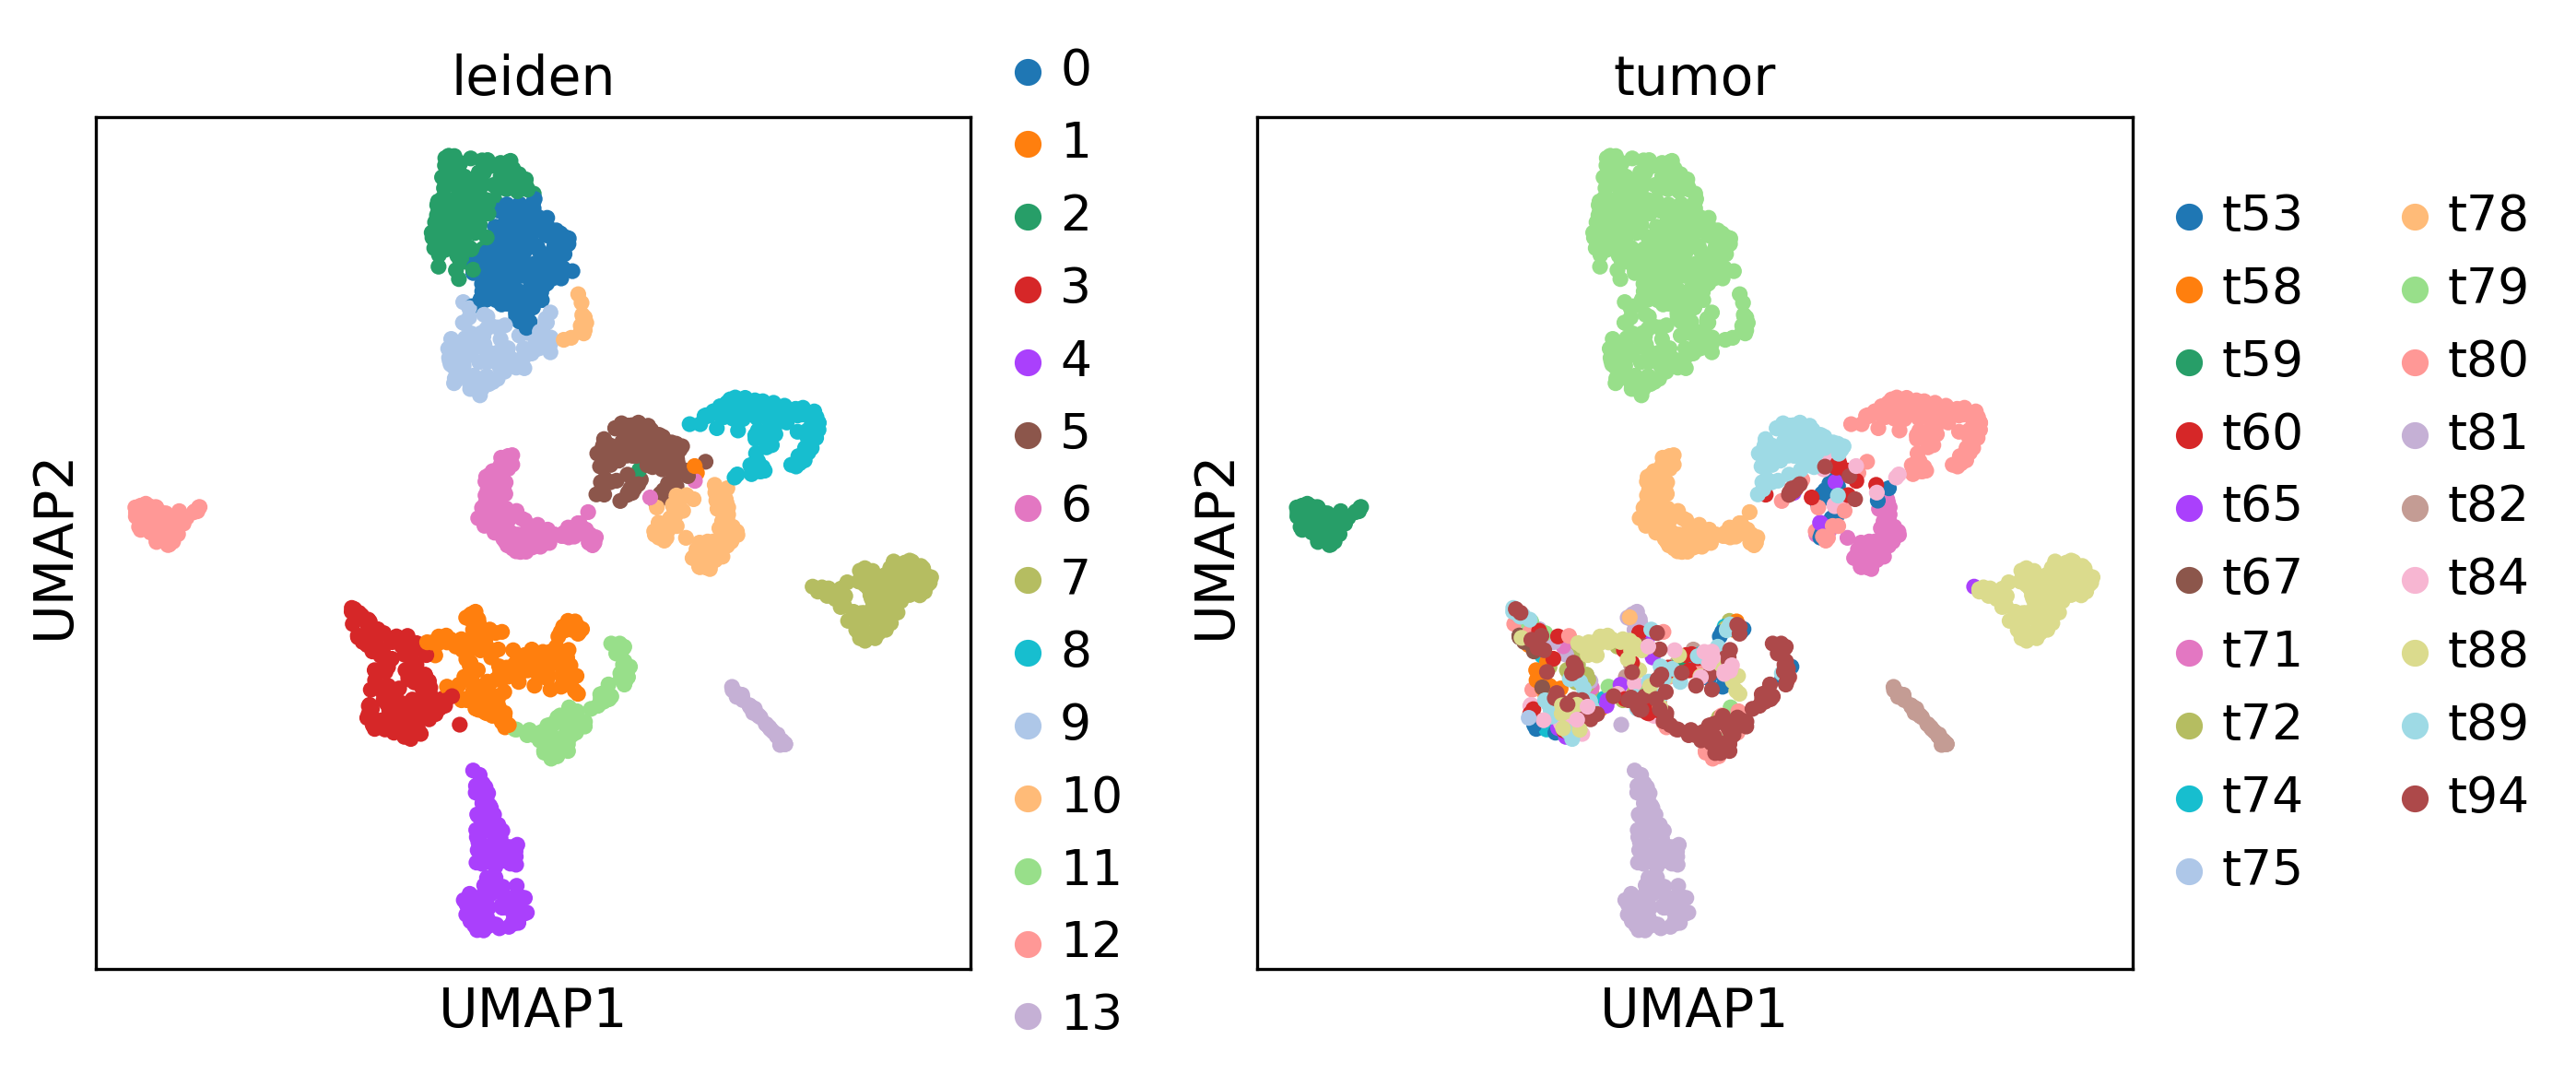

In [ ]:

sc.pl.umap(ge_cancer, color= ["leiden","tumor"])


## 1.2 We see 14 clusters clusters of cancer cells seperated by tumor source

### Performing leiden clustering and UMAP visualization on immune cells

Now we'll perform the similar analysis on the non-malignant cells, which are mostly immune cells. 

In [ ]:

sc.pp.scale(ge_immune, max_value=10)
sc.tl.pca(ge_immune, svd_solver='arpack')
sc.pp.neighbors(ge_immune, n_neighbors= 15, n_pcs=15, random_state=0)
sc.tl.umap(ge_immune, random_state=0)
sc.tl.leiden(ge_immune, resolution = 0.5)

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Similarly, we'll do visualization on the UMAP embedding with different coloring. This time we'll use three different coloring: `color = ["leiden", "tumor", "cell_type_annot_by_author"]`, representing the clusters assigned by louvain, tumor source, and cell types annotated by the authors.

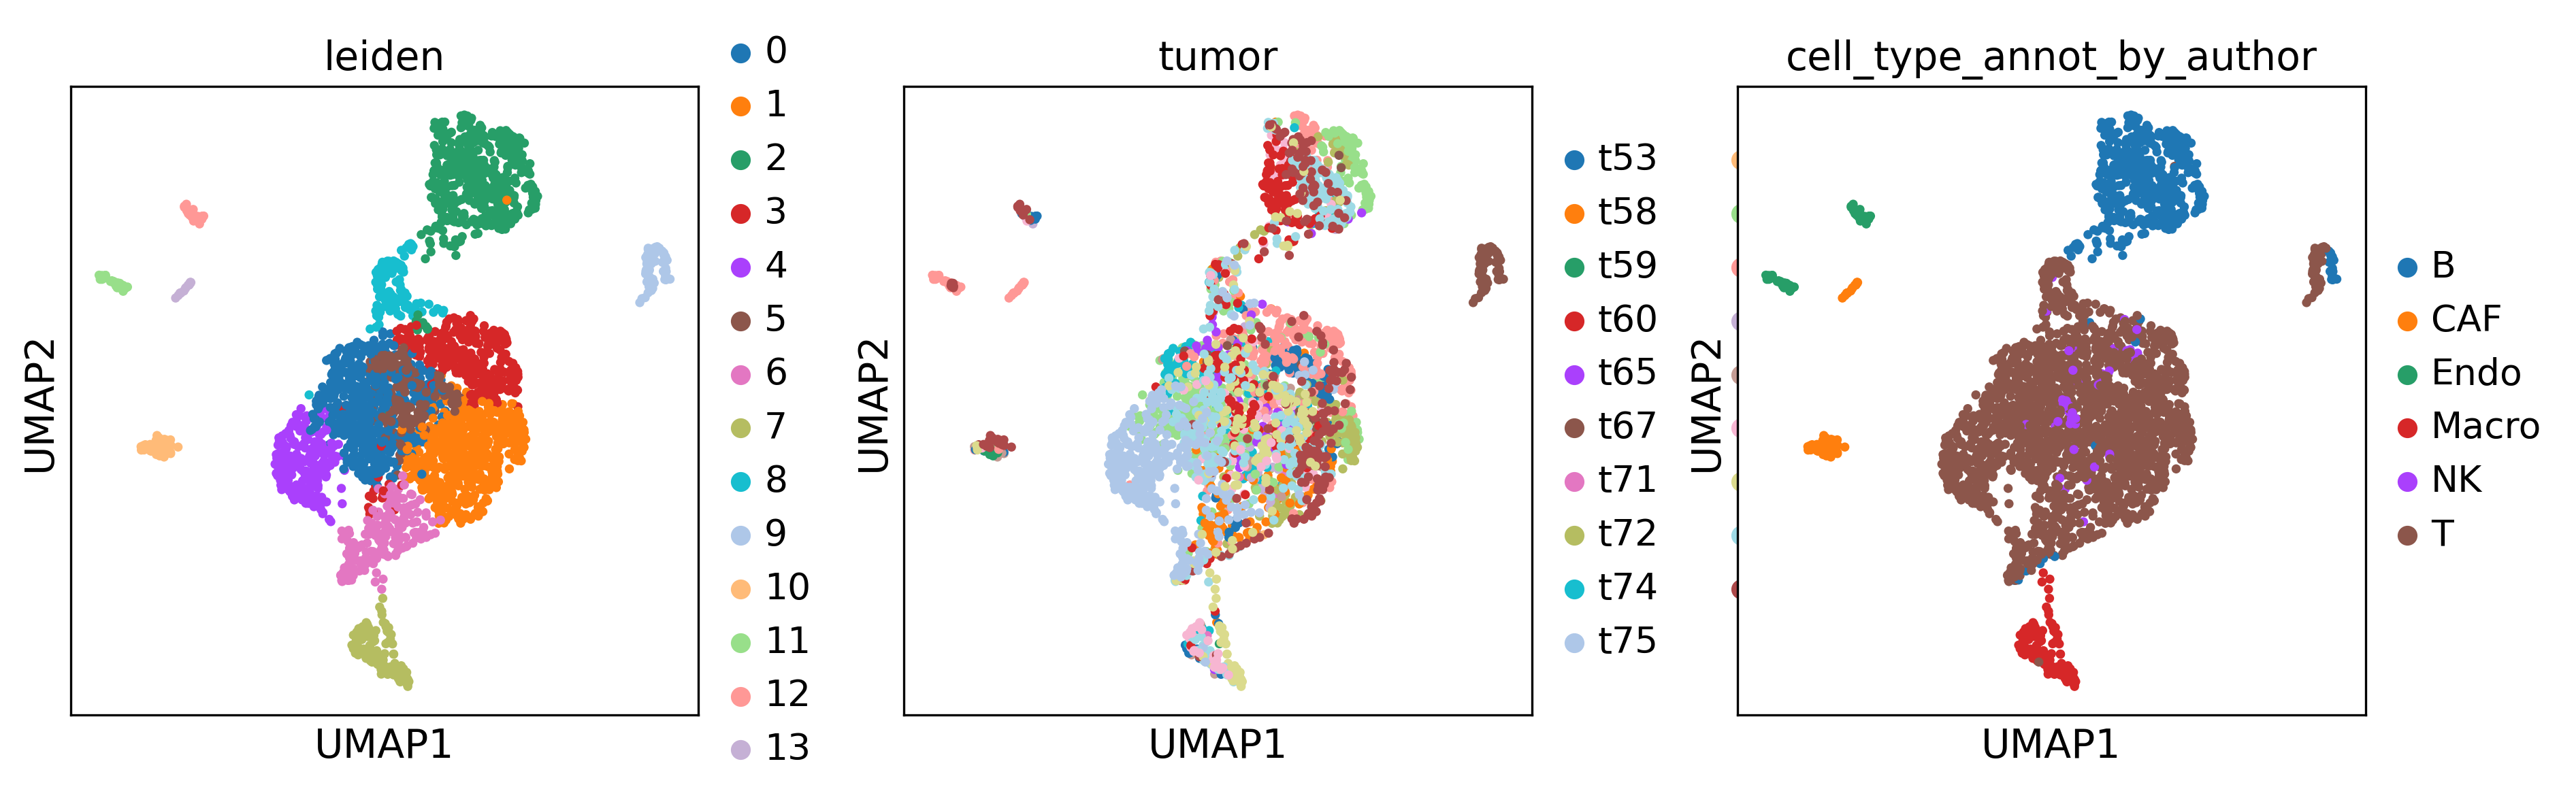

In [ ]:

sc.pl.umap(ge_immune, color= ["leiden","tumor","cell_type_annot_by_author"])


## 1.3 Non malignant cells were clustered more by cell types

Finally, we'll identify the most differentially expressed genes in each louvain cluster, using the `sc.tl.rank_genes_groups` function, with `method="t-test"`. Plot the top differentially expressed genes using `rank_genes_groups_dotplot` to show the 5 top differentially expressed genes with `min_logfoldchange=1`.

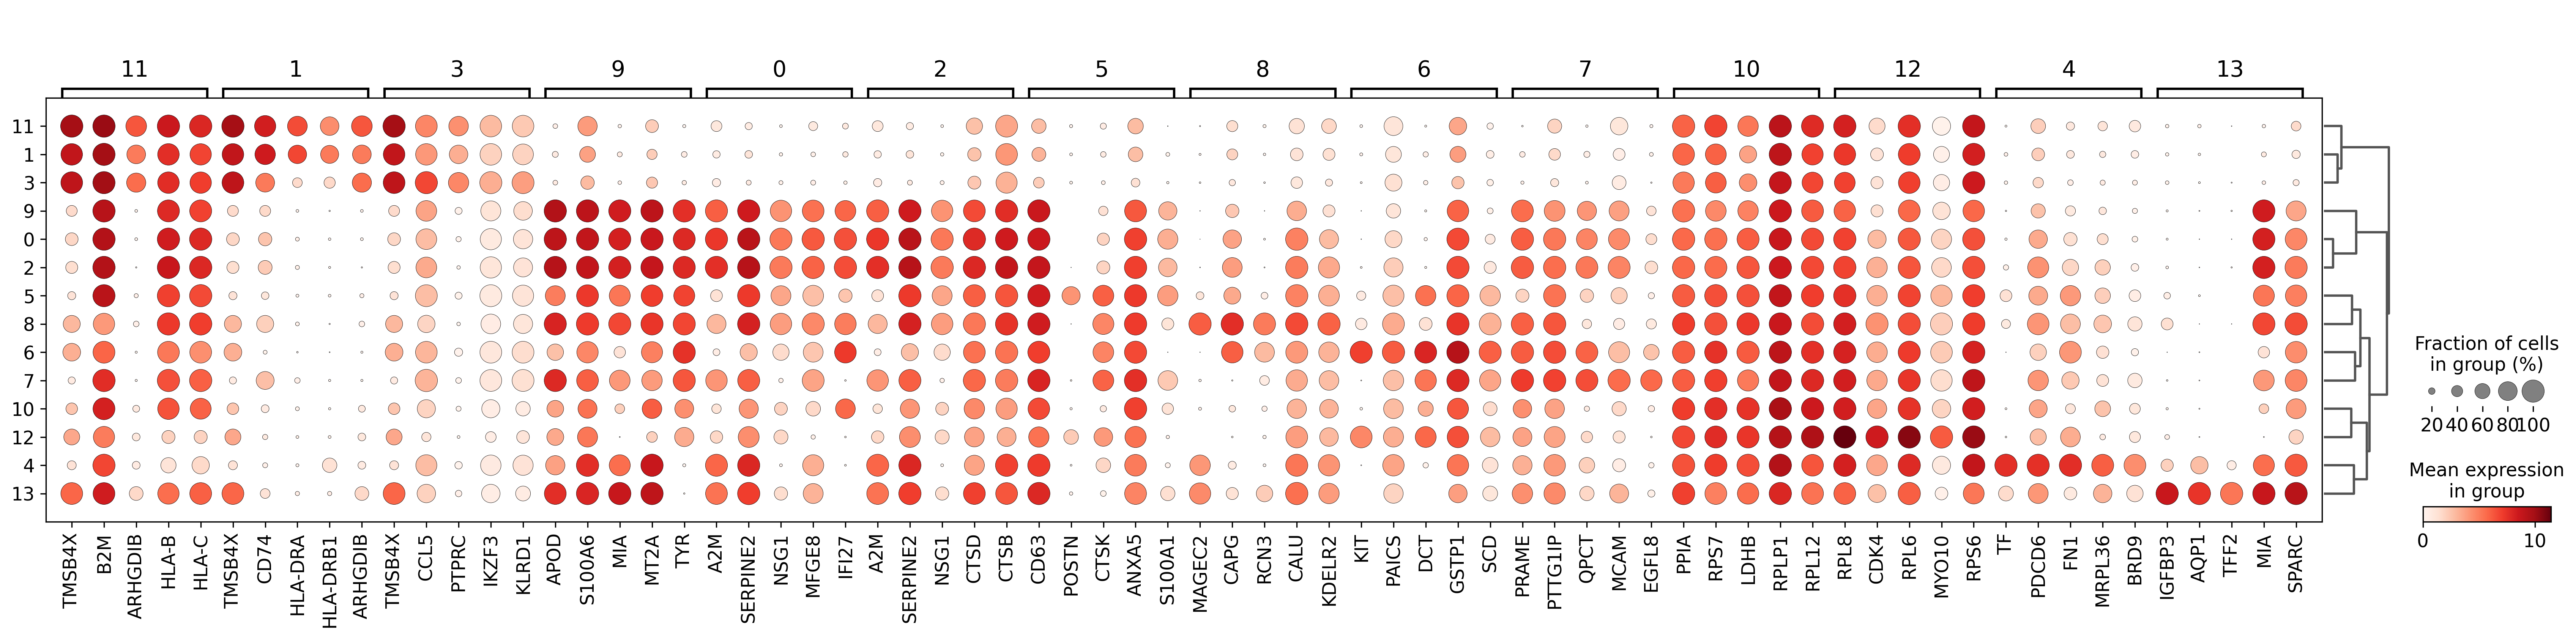

In [ ]:

CLUSTER_COL = "leiden"
deg_key = f"t_{CLUSTER_COL}"
sc.tl.rank_genes_groups(ge_cancer, groupby=CLUSTER_COL, method="t-test", key_added=deg_key)
sc.pl.rank_genes_groups_dotplot(ge_cancer, key=deg_key, min_logfoldchange=1, n_genes=5)


We create a dotplot using the marker genes we used in the class to see if you can define different cell types.

categories: 0, 1, 2, etc.
var_group_labels: T, CD4, CD8, etc.


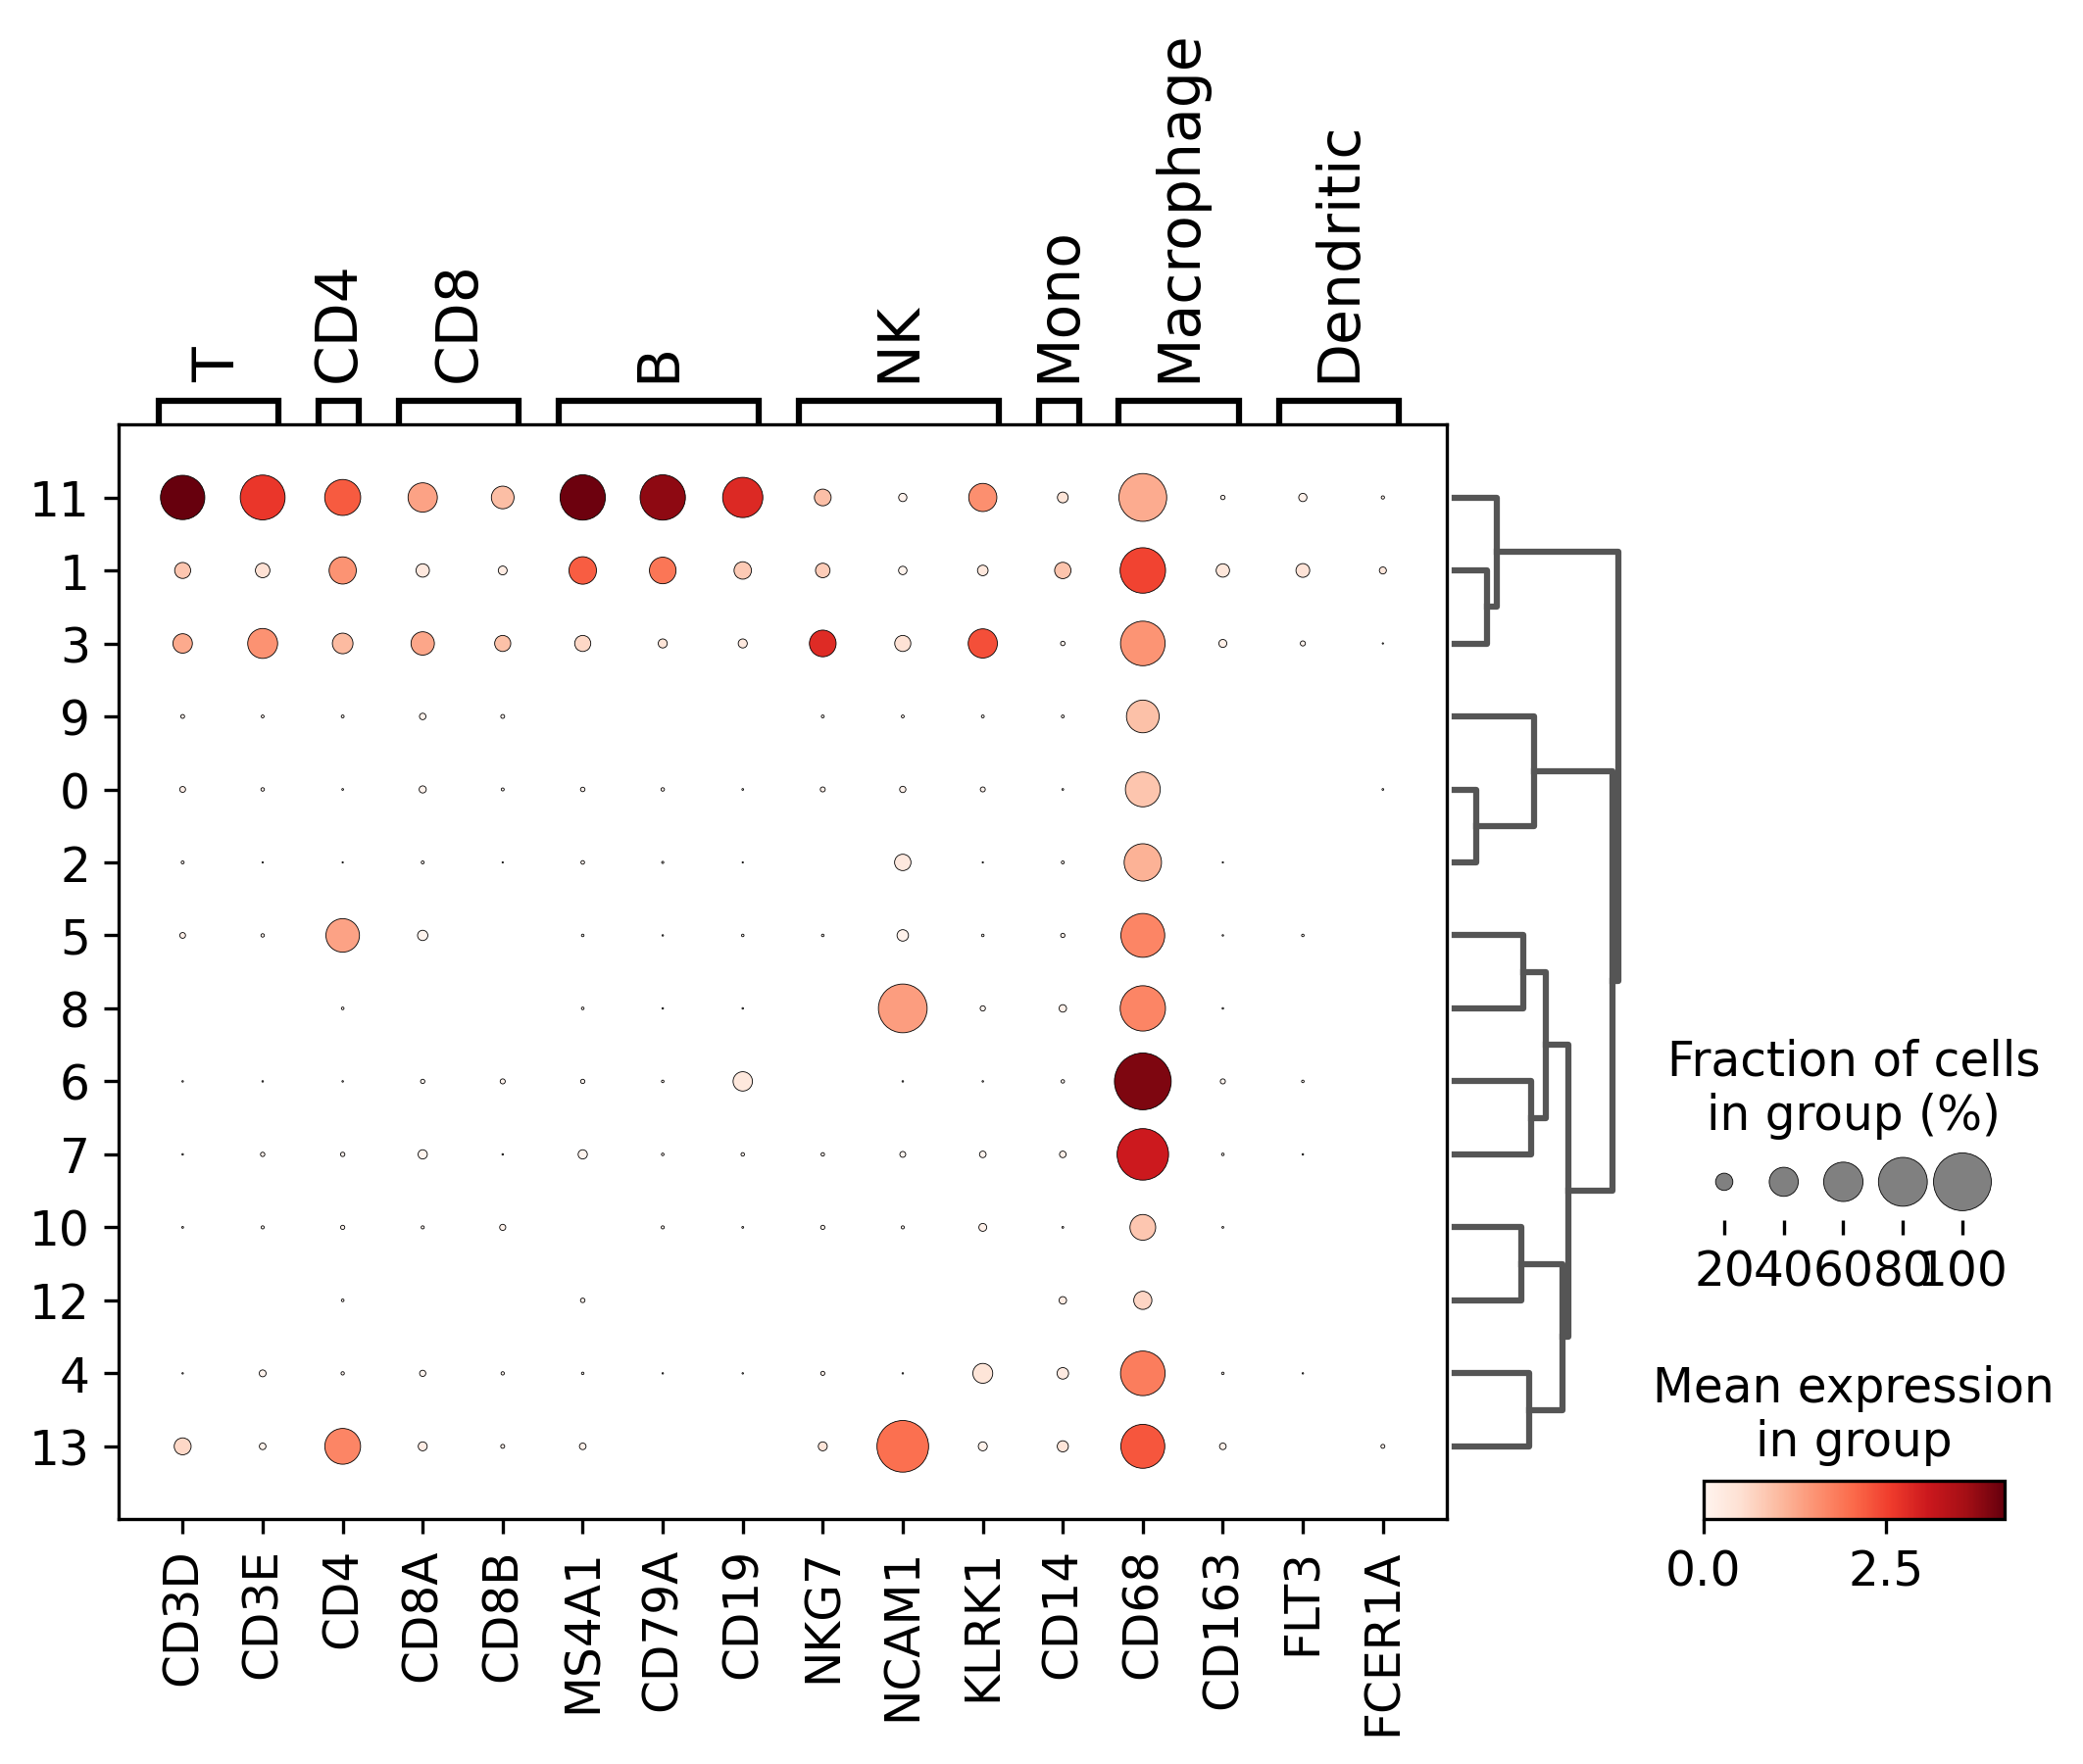

In [ ]:

marker_genes = {
    'T': ['CD3D', 'CD3E'], # T cell
    'CD4': ['CD4'], # CD4 T cell
    'CD8': ['CD8A', 'CD8B'], # CD8 T cell
    'B': ['MS4A1', 'CD79A', 'CD19'], # B cell,
    'NK': ['NKG7', 'NCAM1', 'KLRK1'], # NK cell
    'Mono': ['CD14'], # CD14+ monocytes
    'Macrophage': ['CD68', 'CD163'], # macrophage
    'Dendritic': ['FLT3', 'FCER1A'], # dendritic
}

sc.pl.dotplot(ge_cancer, marker_genes, groupby=CLUSTER_COL, dendrogram=True)


categories: 0, 1, 2, etc.
var_group_labels: T, CD4, CD8, etc.


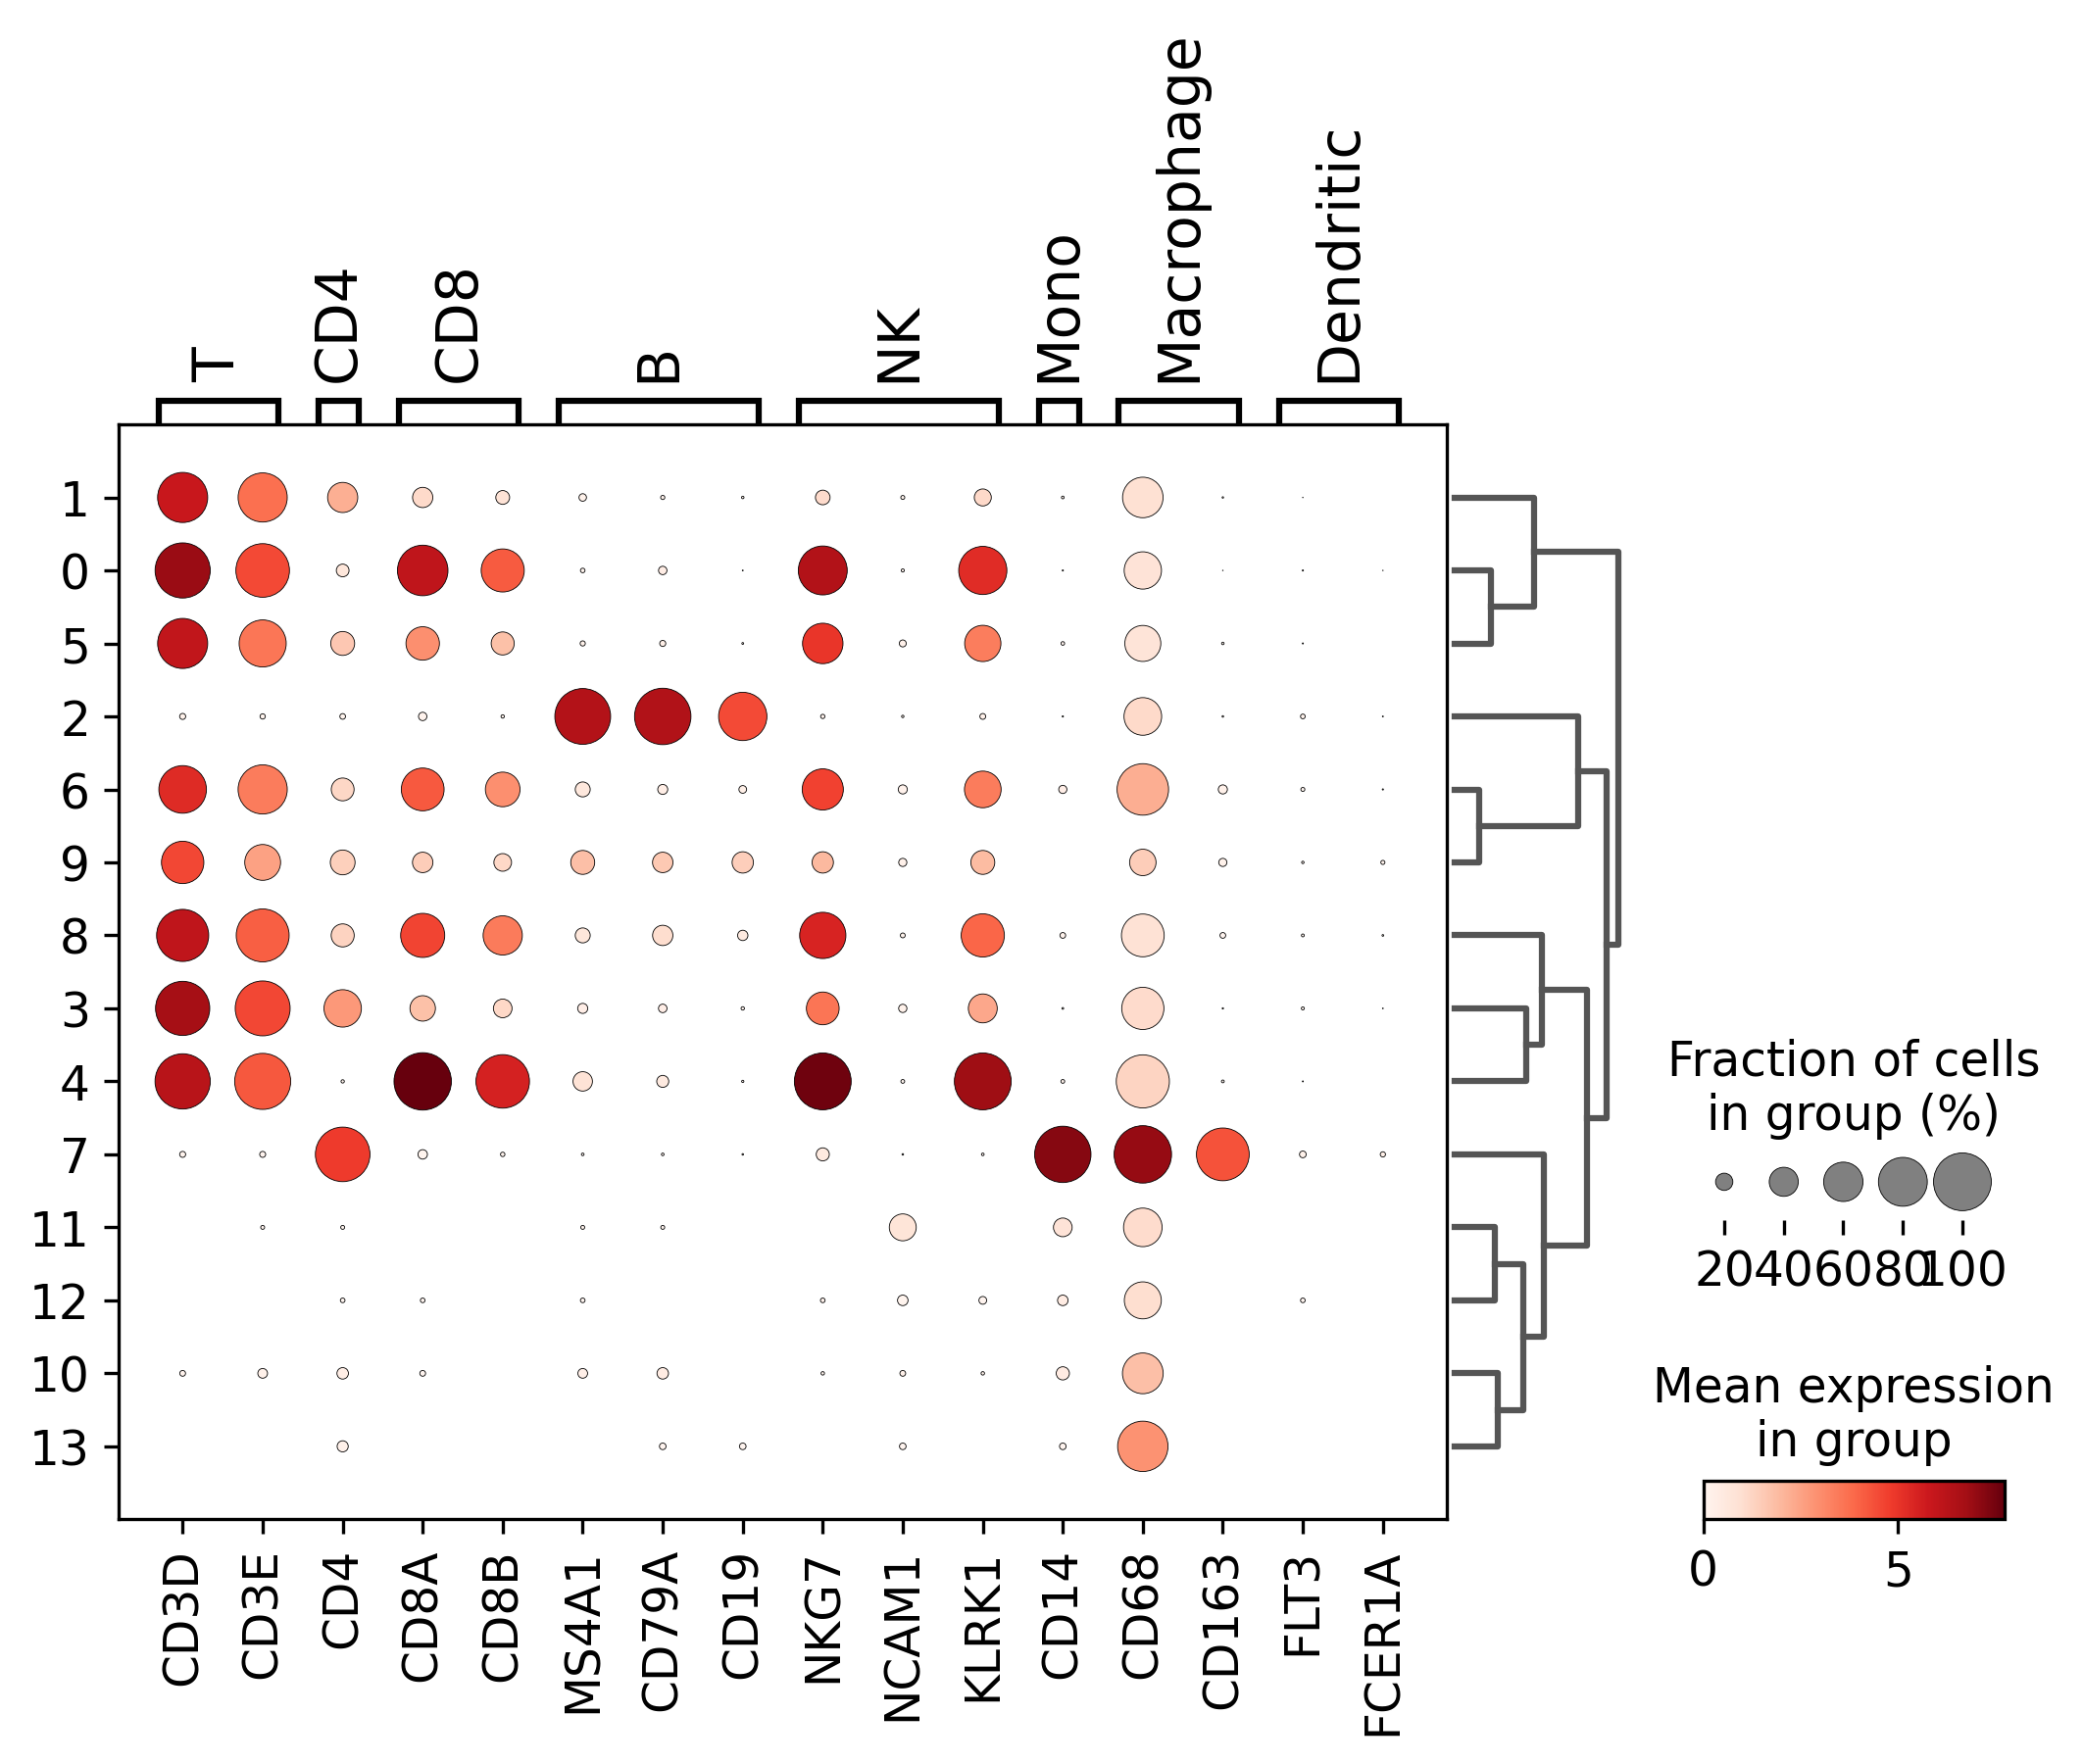

In [ ]:
sc.pl.dotplot(ge_immune, marker_genes, groupby=CLUSTER_COL, dendrogram=True)

## 1.4
T-cells = 0, 8, 3 and 4th cluster
CD4 = 7th cluster
CD8 = 0 and 8th cluster
B cells = 2nd cluster
Macrophages/Monocytes = 4th cluster

## 2: inter tumor heterogeneity vs intra tumor heterogeneity

We will explore another usage of single cell RNASeq data: aggregate cell-level data into sample-level data for tumor genomic subtype identification. We will use the same single cell melanoma data as in Problem 1. 

In melanoma, one of the genomic phenotype is based on the MITF / AXL program. The two genes are observed to be anti-correlated, meaning if one gene is high, the other will be low. The AXL-high subtype melanoma tumors have been linked to intrinsic resistance to RAF and MEK inhibition [[Müller _et al._](https://www.ncbi.nlm.nih.gov/pubmed/25502142?dopt=Abstract)].

We will investigate how do the AXL-high or MITF-high on the bulk RNASeq level can be deconvoluted in single-cell level to get an idea about intra-tumor heterogeneity.

First, to define the MITF program and AXL program, let's identify the co-expressed genes in order to reduce the dropout effect and generate more robust features.

Using our single cell expression matrix of **cancer cells** (_i.e._ `ge_cancer`), let's calculate the correlation between MITF and all the genes, and identify 10 genes with highest positive Spearman rank correlation with the gene MITF (we can use the `scipy.stats.spearmanr`).




In [ ]:
import numpy as np
import pandas as pd

ge_cancer = (ge[ge.obs['cell_type_annot_by_author'] == "malignant"])
ge_cancer.layers["log_transformed"] = np.log1p(ge_cancer.X)
ge_df = ge_cancer.to_df(layer="log_transformed")


gene_MITF = ge_df["MITF"]
gene_MITF = pd.DataFrame(gene_MITF)
ge_df

C9orf152     RPS11     ELMO2  CREB3L1  \
Cy71_CD45_D08_S524_comb                   0.0  2.333405  1.139850      0.0   
Cy81_FNA_CD45_B01_S301_comb               0.0  2.184657  0.000000      0.0   
Cy80_II_CD45_B07_S883_comb                0.0  2.233139  0.000000      0.0   
Cy81_Bulk_CD45_B10_S118_comb              0.0  2.178563  0.573237      0.0   
Cy71_CD45_B05_S497_comb                   0.0  2.244670  0.000000      0.0   
...                                       ...       ...       ...      ...   
CY84_PRIM_POS_All_8_A01_S97_comb          0.0  2.044034  1.026615      0.0   
CY84_PRIM_POS_All_8_E11_S155_comb         0.0  0.000000  0.000000      0.0   
CY94_CD45NEG_CD90POS_2_D08_S44_comb       0.0  2.192145  1.519382      0.0   
CY84_PRIM_POS_All_7_A01_S193_comb         0.0  1.999965  1.244356      0.0   
CY75_1_CD45_CD8_7__S274_comb              0.0  1.607376  0.000000      0.0   

                                        PNMA1      MMP2   TMEM216  \
Cy71_CD45_D08_S524_comb              0.000000  0.552804  0.000000   
Cy81_FNA_CD45_B01_S301_comb          0.000000  0.000000  0.000000   
Cy80_II_CD45_B07_S883_comb           0.000000  0.000000  1.567553   
Cy81_Bulk_CD45_B10_S118_comb         0.000000  0.000000  0.000000   
Cy71_CD45_B05_S497_comb              0.000000  0.000000  0.000000   
...                                       ...       ...       ...   
CY84_PRIM_POS_All_8_A01_S97_comb     0.743983  0.000000  0.868570   
CY84_PRIM_POS_All_8_E11_S155_comb    1.881478  0.000000  0.000000   
CY94_CD45NEG_CD90POS_2_D08_S44_comb  0.000000  0.000000  1.680995   
CY84_PRIM_POS_All_7_A01_S193_comb    0.982715  0.000000  0.000000   
CY75_1_CD45_CD8_7__S274_comb         0.000000  0.000000  0.254696   

                                     TRAF3IP2-AS1  LRRC37A5P  LOC653712  ...  \
Cy71_CD45_D08_S524_comb                  0.480758        0.0        0.0  ...   
Cy81_FNA_CD45_B01_S301_comb              0.675467        0.0        0.0  ...   
Cy80_II_CD45_B07_S883_comb               0.905634        0.0        0.0  ...   
Cy81_Bulk_CD45_B10_S118_comb             1.425034        0.0        0.0  ...   
Cy71_CD45_B05_S497_comb                  0.000000        0.0        0.0  ...   
...                                           ...        ...        ...  ...   
CY84_PRIM_POS_All_8_A01_S97_comb         0.458127        0.0        0.0  ...   
CY84_PRIM_POS_All_8_E11_S155_comb        0.811908        0.0        0.0  ...   
CY94_CD45NEG_CD90POS_2_D08_S44_comb      0.455068        0.0        0.0  ...   
CY84_PRIM_POS_All_7_A01_S193_comb        0.998166        0.0        0.0  ...   
CY75_1_CD45_CD8_7__S274_comb             0.983800        0.0        0.0  ...   

                                        GPLD1  SNORD115-39     RAB8A  RXFP2  \
Cy71_CD45_D08_S524_comb              0.691341          0.0  1.325323    0.0   
Cy81_FNA_CD45_B01_S301_comb          0.208176          0.0  1.647446    0.0   
Cy80_II_CD45_B07_S883_comb           0.000000          0.0  1.272706    0.0   
Cy81_Bulk_CD45_B10_S118_comb         0.371536          0.0  1.558692    0.0   
Cy71_CD45_B05_S497_comb              0.000000          0.0  0.000000    0.0   
...                                       ...          ...       ...    ...   
CY84_PRIM_POS_All_8_A01_S97_comb     0.652674          0.0  1.534369    0.0   
CY84_PRIM_POS_All_8_E11_S155_comb    0.350713          0.0  0.000000    0.0   
CY94_CD45NEG_CD90POS_2_D08_S44_comb  0.385188          0.0  0.000000    0.0   
CY84_PRIM_POS_All_7_A01_S193_comb    0.206176          0.0  1.658057    0.0   
CY75_1_CD45_CD8_7__S274_comb         0.726679          0.0  0.000000    0.0   

                                        PCIF1   PIK3IP1    SNRPD2   SLC39A6  \
Cy71_CD45_D08_S524_comb              1.542913  0.000000  1.606855  1.584674   
Cy81_FNA_CD45_B01_S301_comb          0.000000  0.000000  1.834803  1.561507   
Cy80_II_CD45_B07_S883_comb           0.000000  0.000000  1.957613  1.023026   
Cy81_Bulk_CD45_B10_S118_comb         1.712879

In [ ]:
from scipy.stats import spearmanr
spearman_values = {}
for i in ge_df:
 x = spearmanr(ge_df[i].values, ge_df["MITF"].values)
 if not np.isnan(x.correlation):
  spearman_values[i] = x
print(spearman_values)
 
 

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


{'C9orf152': SpearmanrResult(correlation=-0.028551746794696846, pvalue=0.23149188202436274), 'RPS11': SpearmanrResult(correlation=-0.1425578002121536, pvalue=1.9290442266511442e-09), 'ELMO2': SpearmanrResult(correlation=0.15062420415336186, pvalue=2.192686981567589e-10), 'CREB3L1': SpearmanrResult(correlation=-0.07931888721983288, pvalue=0.000872828257384399), 'PNMA1': SpearmanrResult(correlation=0.24035399594932202, pvalue=1.6017317589085354e-24), 'MMP2': SpearmanrResult(correlation=0.08270594620282762, pvalue=0.0005181015759966953), 'TMEM216': SpearmanrResult(correlation=-0.0033558821432112004, pvalue=0.8881800582104249), 'TRAF3IP2-AS1': SpearmanrResult(correlation=-0.13253599669678615, pvalue=2.4371045198866784e-08), 'LRRC37A5P': SpearmanrResult(correlation=-0.02994760701906012, pvalue=0.20946172211790803), 'LOC653712': SpearmanrResult(correlation=-0.06618106960494259, pvalue=0.005504174760235768), 'C10orf90': SpearmanrResult(correlation=0.30658271132176307, pvalue=1.419841268120546


#### 2.1. Identifying the top 10 genes with highest positive Spearman correlation with MITF.(INCLUDING MITF)

In [ ]:
sorted(spearman_values.items(), key=lambda x:x[1], reverse = True)[:10]


[('MITF', SpearmanrResult(correlation=1.0, pvalue=0.0)),
 ('PMEL',
  SpearmanrResult(correlation=0.6565367389145746, pvalue=2.65134760631915e-217)),
 ('MLANA',
  SpearmanrResult(correlation=0.6342551341806707, pvalue=1.747086239660797e-198)),
 ('GPNMB',
  SpearmanrResult(correlation=0.6206644718220281, pvalue=9.540441320395181e-188)),
 ('GPR143',
  SpearmanrResult(correlation=0.6027571185014862, pvalue=2.2088767629584985e-174)),
 ('ASAH1',
  SpearmanrResult(correlation=0.6005884020380354, pvalue=8.044487693515e-173)),
 ('TYR',
  SpearmanrResult(correlation=0.5872470939897794, pvalue=1.787212942840942e-163)),
 ('MLPH',
  SpearmanrResult(correlation=0.5867857567271978, pvalue=3.6951104530947255e-163)),
 ('SDCBP',
  SpearmanrResult(correlation=0.5845168762863772, pvalue=1.2932129201584332e-161)),
 ('TFAP2A',
  SpearmanrResult(correlation=0.582484606833072, pvalue=3.0505321265536017e-160))]

Performing the same calculation with AXL. Identifying the top 10 genes with highest positive Spearman correlation with AXL.

In [ ]:
gene_AXL = ge_df["AXL"]
gene_AXL = pd.DataFrame(gene_AXL)
gene_AXL


AXL
Cy71_CD45_D08_S524_comb              0.272947
Cy81_FNA_CD45_B01_S301_comb          0.474319
Cy80_II_CD45_B07_S883_comb           0.759309
Cy81_Bulk_CD45_B10_S118_comb         0.528791
Cy71_CD45_B05_S497_comb              1.357380
...                                       ...
CY84_PRIM_POS_All_8_A01_S97_comb     1.271052
CY84_PRIM_POS_All_8_E11_S155_comb    0.755652
CY94_CD45NEG_CD90POS_2_D08_S44_comb  0.663260
CY84_PRIM_POS_All_7_A01_S193_comb    1.016932
CY75_1_CD45_CD8_7__S274_comb         1.032900

[1758 rows x 1 columns]

In [ ]:
from scipy.stats import spearmanr
spearman_values = {}
for i in ge_df:
 x = spearmanr(ge_df[i].values, gene_AXL.values)
 if not np.isnan(x.correlation):
  spearman_values[i] = x
 

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())



#### 2.2.The top 10 genes with highest positive Spearman correlation with AXL. (INCLUDING AXL)

In [ ]:
sorted(spearman_values.items(), key=lambda x:x[1], reverse = True)[:10]

[('AXL', SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)),
 ('CCL5',
  SpearmanrResult(correlation=0.4085578634765259, pvalue=1.0722205769029055e-71)),
 ('ZNF793',
  SpearmanrResult(correlation=0.40533051134000003, pvalue=1.71429916276665e-70)),
 ('PRICKLE2-AS3',
  SpearmanrResult(correlation=0.40249342343299577, pvalue=1.9116217075084996e-69)),
 ('FBLIM1',
  SpearmanrResult(correlation=0.3926237431708414, pvalue=7.019794664092841e-66)),
 ('TNFAIP8L1',
  SpearmanrResult(correlation=0.3918016133797678, pvalue=1.3735366082803168e-65)),
 ('LOC90834',
  SpearmanrResult(correlation=0.3912800482080256, pvalue=2.10063543576184e-65)),
 ('SLFNL1-AS1',
  SpearmanrResult(correlation=0.38528215679804984, pvalue=2.6325444347966375e-63)),
 ('LAIR1',
  SpearmanrResult(correlation=0.38520359454617403, pvalue=2.8026396577038585e-63)),
 ('TLCD2',
  SpearmanrResult(correlation=0.38286239400742905, pvalue=1.7967402369715695e-62))]

With the two co-expressed gene sets defined. we now calculate the `MITF_geneset` expression for each cell as the mean expression of the 10 MITF-correlated genes, and the `AXL_geneset` expression for each cell as the mean expression of the 10 AXL-correlated genes.

In [ ]:
MITF = ge_df[["MITF", "PMEL", "MLANA", "GPNMB", "GPR143", "ASAH1", "TYR", "MLPH", "SDCBP", "TFAP2A"]]
AXL = ge_df[["AXL", "CCL5", "ZNF793", "PRICKLE2-AS3", "FBLIM1", "TNFAIP8L1", "LOC90834", "SLFNL1-AS1", "LAIR1", "TLCD2"]]
MITF_mean = MITF.mean(axis=1)
MITF_mean = pd.DataFrame(MITF_mean)
AXL_mean = AXL.mean(axis=1)
AXL_mean = pd.DataFrame(AXL_mean)
print(MITF_mean.head())
print(AXL_mean.head())

                                     0
Cy71_CD45_D08_S524_comb       1.920206
Cy81_FNA_CD45_B01_S301_comb   0.826523
Cy80_II_CD45_B07_S883_comb    1.741814
Cy81_Bulk_CD45_B10_S118_comb  1.001801
Cy71_CD45_B05_S497_comb       1.792960
                                     0
Cy71_CD45_D08_S524_comb       0.777633
Cy81_FNA_CD45_B01_S301_comb   0.954756
Cy80_II_CD45_B07_S883_comb    0.419005
Cy81_Bulk_CD45_B10_S118_comb  0.880211
Cy71_CD45_B05_S497_comb       0.812555


scatter plot showing on one axis the MITF geneset expression, and AXL geneset expression on the other axis.

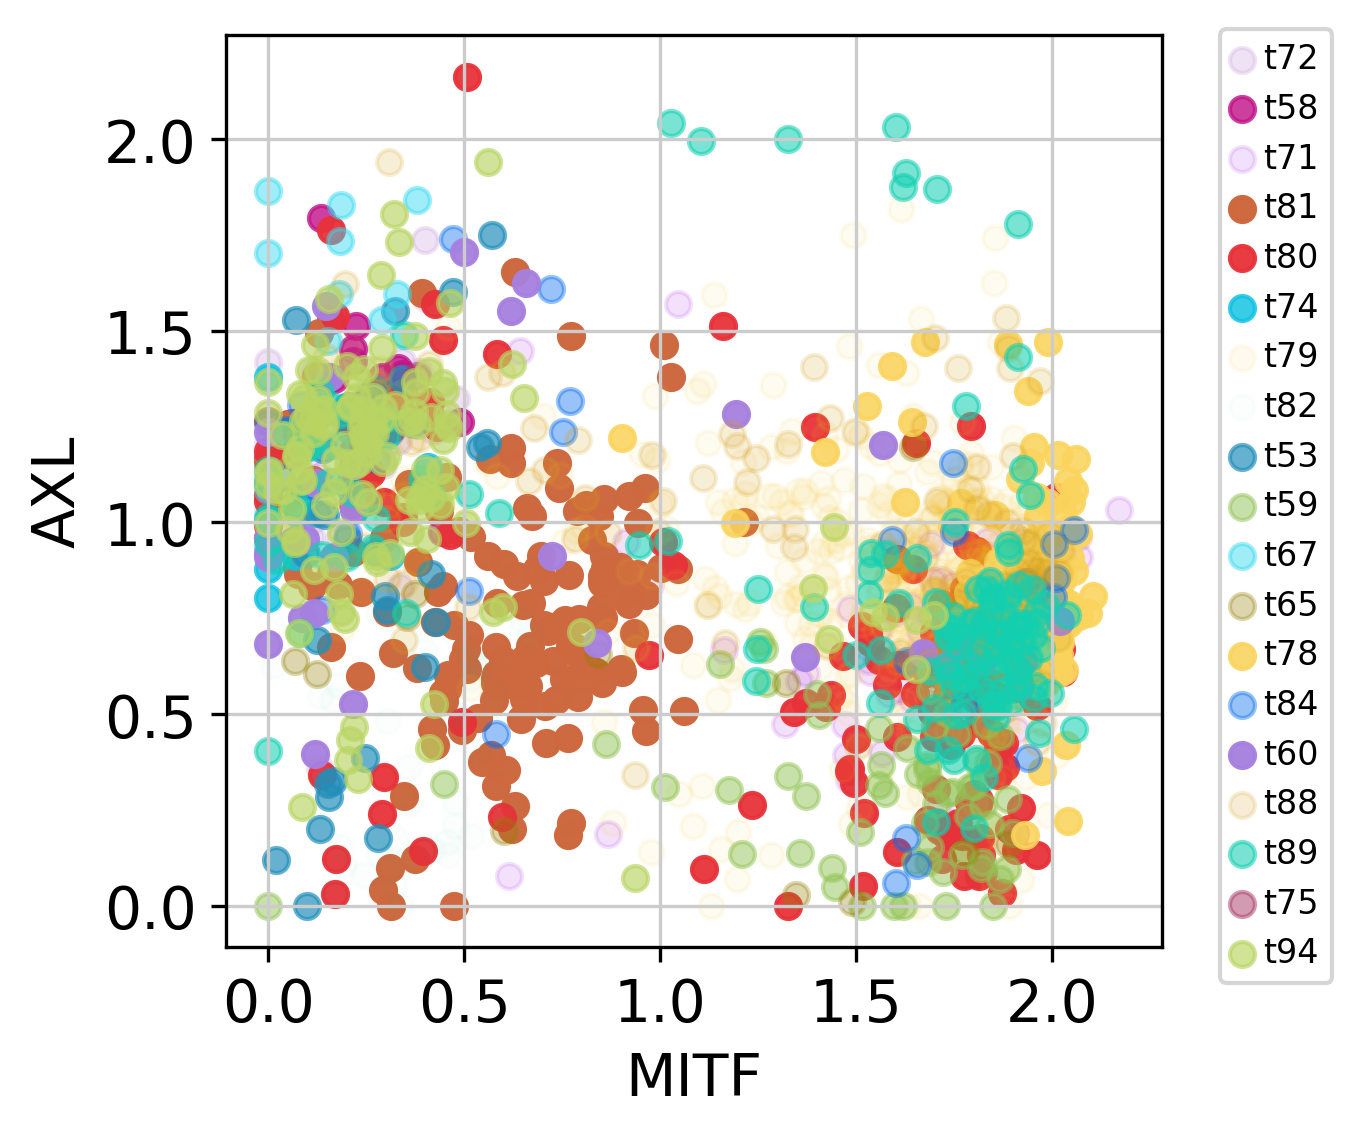

In [ ]:

from matplotlib import axes
import matplotlib.pyplot as plt
import random
fig, ax = plt.subplots()
for tumor in ge.obs['tumor'].unique():
  tumor_cells = ge.obs[ge.obs['tumor'] == tumor].index.unique()
  g = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)]) ## code for colormap
  tumor_cells_AXL = []
  for cell in tumor_cells:
    if cell in AXL_mean.index.values:
     tumor_cells_AXL.append(cell)

      

  tumor_cells_MITF = []
  for cell in tumor_cells:
    if cell in MITF_mean.index.values:
     tumor_cells_MITF.append(cell)

      

  ax.scatter(MITF_mean.loc[tumor_cells_MITF], AXL_mean.loc[tumor_cells_AXL], c=g, label=tumor)
plt.xlabel('MITF')
plt.ylabel('AXL')
ax.legend(fontsize = 8, loc = 1, bbox_to_anchor=(1.2, 1.025))
plt.show()


Next, we'll see how does the expression pattern look like on the tumor-level. Aggregate the cell-level gene expression into tumor-level gene expression. This can be done by taking the average of all the cells' gene set expression into each tumor's gene set expression. After the aggregation, you should end up with a data frame with each tumor as rows (in total 19 rows), and two columns `MITF_geneset` and `AXL_geneset`.

In [ ]:

temp_list = []
for tumor in ge.obs['tumor'].unique():
  tumor_cells = ge.obs[ge.obs['tumor'] == tumor].index.unique()

  tumor_cells_AXL = []
  for cell in tumor_cells:
    if cell in AXL_mean.index.values:
     tumor_cells_AXL.append(cell)

  

  tumor_cells_MITF = []
  for cell in tumor_cells:
    if cell in MITF_mean.index.values:
     tumor_cells_MITF.append(cell)
  
  axl = AXL_mean.loc[tumor_cells_AXL].mean()[0]
  mitf = MITF_mean.loc[tumor_cells_MITF].mean()[0]
  temp = [tumor,axl,mitf]
  temp_list.append(temp)
temp_list
all_tumor = pd.DataFrame(temp_list, columns=['Tumor','AXL','MITF'])
all_tumor


Tumor       AXL      MITF
0    t72  1.192695  0.236412
1    t58  1.351127  0.228829
2    t71  0.721330  1.548521
3    t81  0.781036  0.588548
4    t80  0.643362  1.426957
5    t74  1.043329  0.114915
6    t79  0.813116  1.607504
7    t82  0.473011  0.363339
8    t53  0.925072  0.252380
9    t59  0.294311  1.569820
10   t67  1.625318  0.169593
11   t65  0.544804  0.974775
12   t78  0.844904  1.937024
13   t84  0.961102  0.914219
14   t60  0.961273  0.656325
15   t88  0.906428  1.473239
16   t89  0.847794  1.411379
17   t75  1.383280  0.380098
18   t94  1.115679  0.335777

Similarly, doing a scatter plot showing on one axis the MITF geneset expression, and AXL geneset expression on the other axis. 

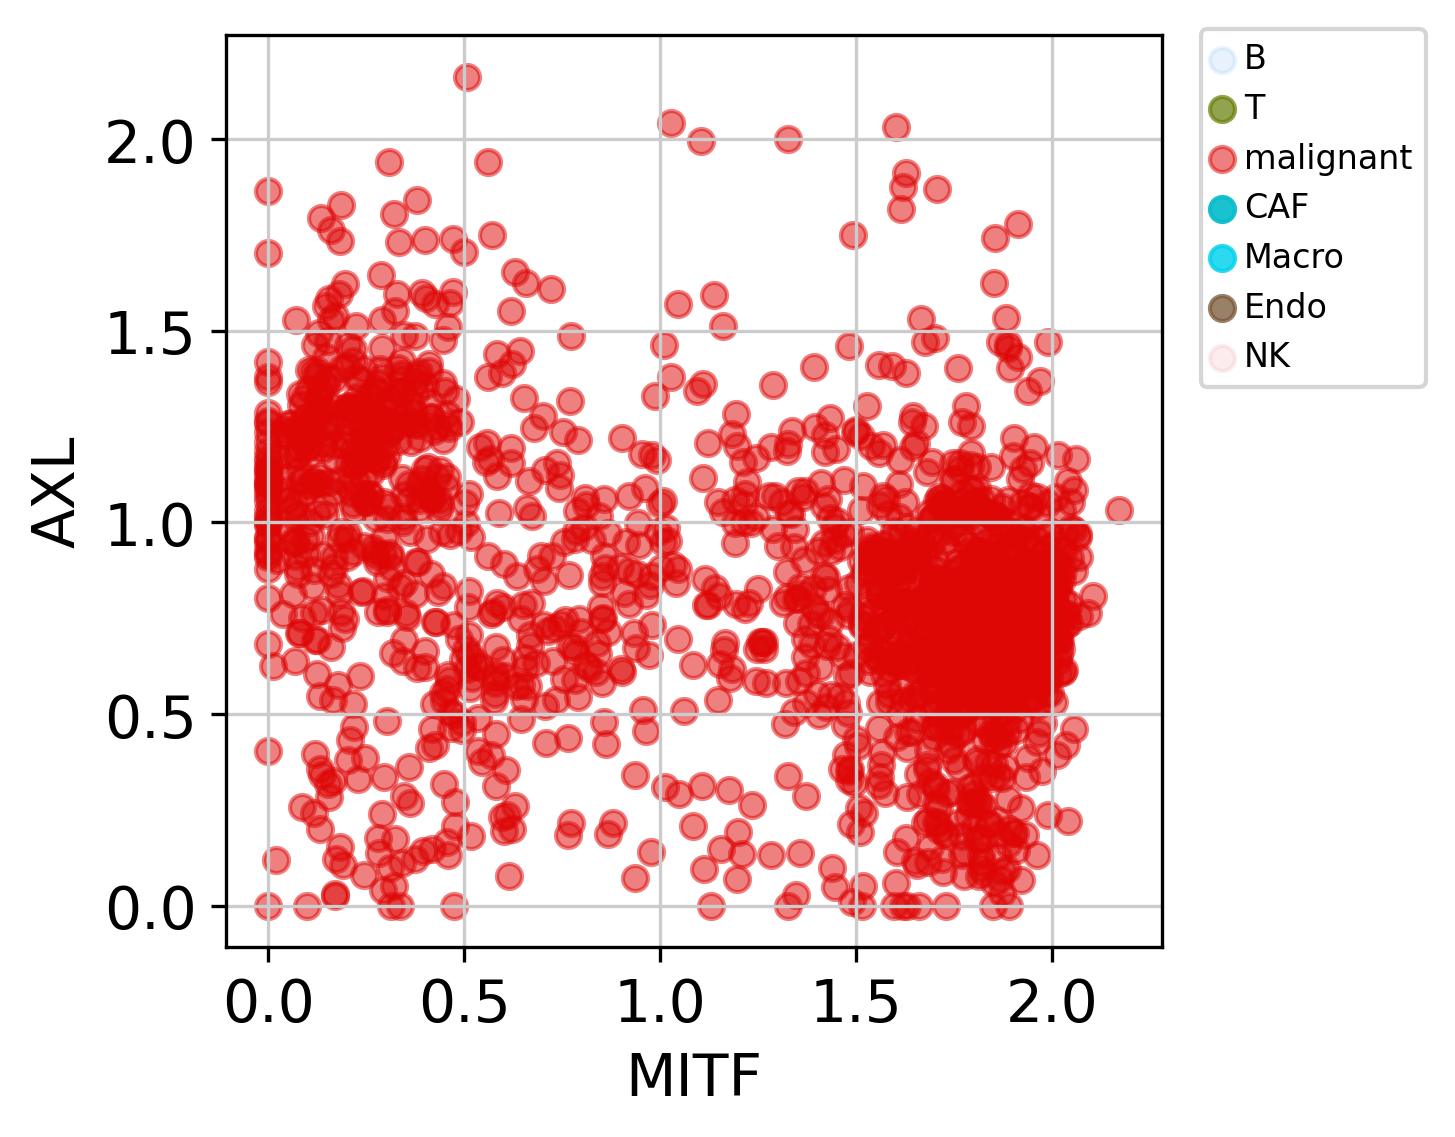

In [ ]:
fig, ax = plt.subplots()
for tumor_1 in ge.obs['cell_type_annot_by_author'].unique():
  tumor_cells_1 = ge.obs[ge.obs['cell_type_annot_by_author'] == tumor_1].index.unique()
  f = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(8)])
  tumor_cells_AXL_1 = []
  for cell_1 in tumor_cells_1:
    if cell_1 in AXL_mean.index.values:
     tumor_cells_AXL_1.append(cell_1)

      

  tumor_cells_MITF_1 = []
  for cell_1 in tumor_cells_1:
    if cell_1 in MITF_mean.index.values:
     tumor_cells_MITF_1.append(cell_1)


  ax.scatter(MITF_mean.loc[tumor_cells_MITF_1], AXL_mean.loc[tumor_cells_AXL_1], c=f, label=tumor_1)
plt.xlabel('MITF')
plt.ylabel('AXL')
ax.legend(fontsize = 8, loc = 1, bbox_to_anchor=(1.3, 1.025))
plt.show()

We do see a negative correlation between the two gene sets on tumor levels. 
We see a similar correlation on cell level i.e cells in tumors have high AXL and low MITF and vice versa